In [1]:
import pandas as pd
import commons as me

knownLos = pd.read_csv('../data/clean/known_los.csv')
len(knownLos)

73

In [2]:
# Removing LOS where I could not pinpoint the observer or target location

knownLos = knownLos.dropna(subset=['from_latitude', 'from_longitude', 'to_latitude', 'to_longitude'])
knownLos['curvature'] = None

len(knownLos)

46

In [3]:
# Removing LOS where the reported distance does not match the actual distance based on identifications

def getKnownLosDistance(los):
    return me.geod.line_length([los.from_longitude, los.to_longitude], [los.from_latitude, los.to_latitude])

knownLos['distance_reported'] = knownLos.distance
knownLos['distance_true'] = round(knownLos.apply(getKnownLosDistance, axis=1)/1000, 3) # in km
knownLos = knownLos.query('abs(distance_true - distance) < 1')

len(knownLos)

34

In [4]:
# Finding the minimum light curvature needed for all known LOS to be possible

testCurvature = 7.7 # Max light curvature to test

while sum(knownLos.curvature.isna()) > 0 and testCurvature >= 1.0: # testCurvature = 1 gives the best LOS conditions

    print(f'Test Curvature: {round(testCurvature, 1)}')
    print(f'LOS Remaining: {sum(knownLos.curvature.isna())}\n')

    missingCurvatureMask = knownLos.curvature.isna()

    for i in knownLos.index[missingCurvatureMask]:
        los = knownLos.loc[i]
    
        observer = me.Summit(latitude=los.from_latitude,
                             longitude=los.from_longitude,
                             elevation=los.from_elevation)

        target = me.Summit(latitude=los.to_latitude,
                           longitude=los.to_longitude,
                           elevation=los.to_elevation)
    
        lineOfSight = me.LineOfSight(observer, target, lightCurvature=testCurvature)
        lineOfSight.processFullLineOfSight()
    
        if not lineOfSight.isObstructed():
            knownLos.at[i, 'curvature'] = round(testCurvature, 1)
    
    allCurvaturesFound = knownLos.curvature.notna().all()
    
    testCurvature -= 0.1

Test Curvature: 7.7
LOS Remaining: 34

Test Curvature: 7.6
LOS Remaining: 2

Test Curvature: 7.5
LOS Remaining: 2

Test Curvature: 7.4
LOS Remaining: 2

Test Curvature: 7.3
LOS Remaining: 2

Test Curvature: 7.2
LOS Remaining: 2

Test Curvature: 7.1
LOS Remaining: 2

Test Curvature: 7.0
LOS Remaining: 2

Test Curvature: 6.9
LOS Remaining: 2

Test Curvature: 6.8
LOS Remaining: 1

Test Curvature: 6.7
LOS Remaining: 1

Test Curvature: 6.6
LOS Remaining: 1

Test Curvature: 6.5
LOS Remaining: 1

Test Curvature: 6.4
LOS Remaining: 1



In [5]:
knownLos = knownLos[['from', 'from_area', 'from_elevation', 'from_latitude', 'from_longitude', 
                     'to', 'to_area', 'to_elevation', 'to_latitude', 'to_longitude', 
                     'distance_reported', 'distance_true', 'curvature']]

knownLos.head()

,from,from_area,from_elevation,from_latitude,from_longitude,to,to_area,to_elevation,to_latitude,to_longitude,distance_reported,distance_true,curvature
0,Finestrelles,Pirineos E (ES),2827,42.414475,2.133279,Pic Gaspard,Alpes (FR),3883,44.99811,6.33042,443,443.011,6.9
1,Bastiments,Pirineos E (ES),2881,42.426120,2.233078,Doigt de Dieu,Alpes (FR),3973,45.00382,6.31445,436,435.503,7.7
2,Bastiments,Pirineos E (ES),2881,42.426120,2.233078,Barre des Ecrins,Alpes (FR),4102,44.92215,6.35953,432,432.529,7.7
3,Canigou,Pirineos E (FR),2784,42.518976,2.456582,Pic Gaspard,Alpes (FR),3867,44.99811,6.33042,416,415.584,7.7
4,Canigou,Pirineos E (FR),2784,42.518976,2.456582,Barre des Ecrins,Alpes (FR),4102,44.92215,6.35953,412,411.961,7.7


In [6]:
knownLos.to_csv('../data/clean/known_los_with_curvature.csv', index=False)

0.020017076028377098 0.02023939257111716


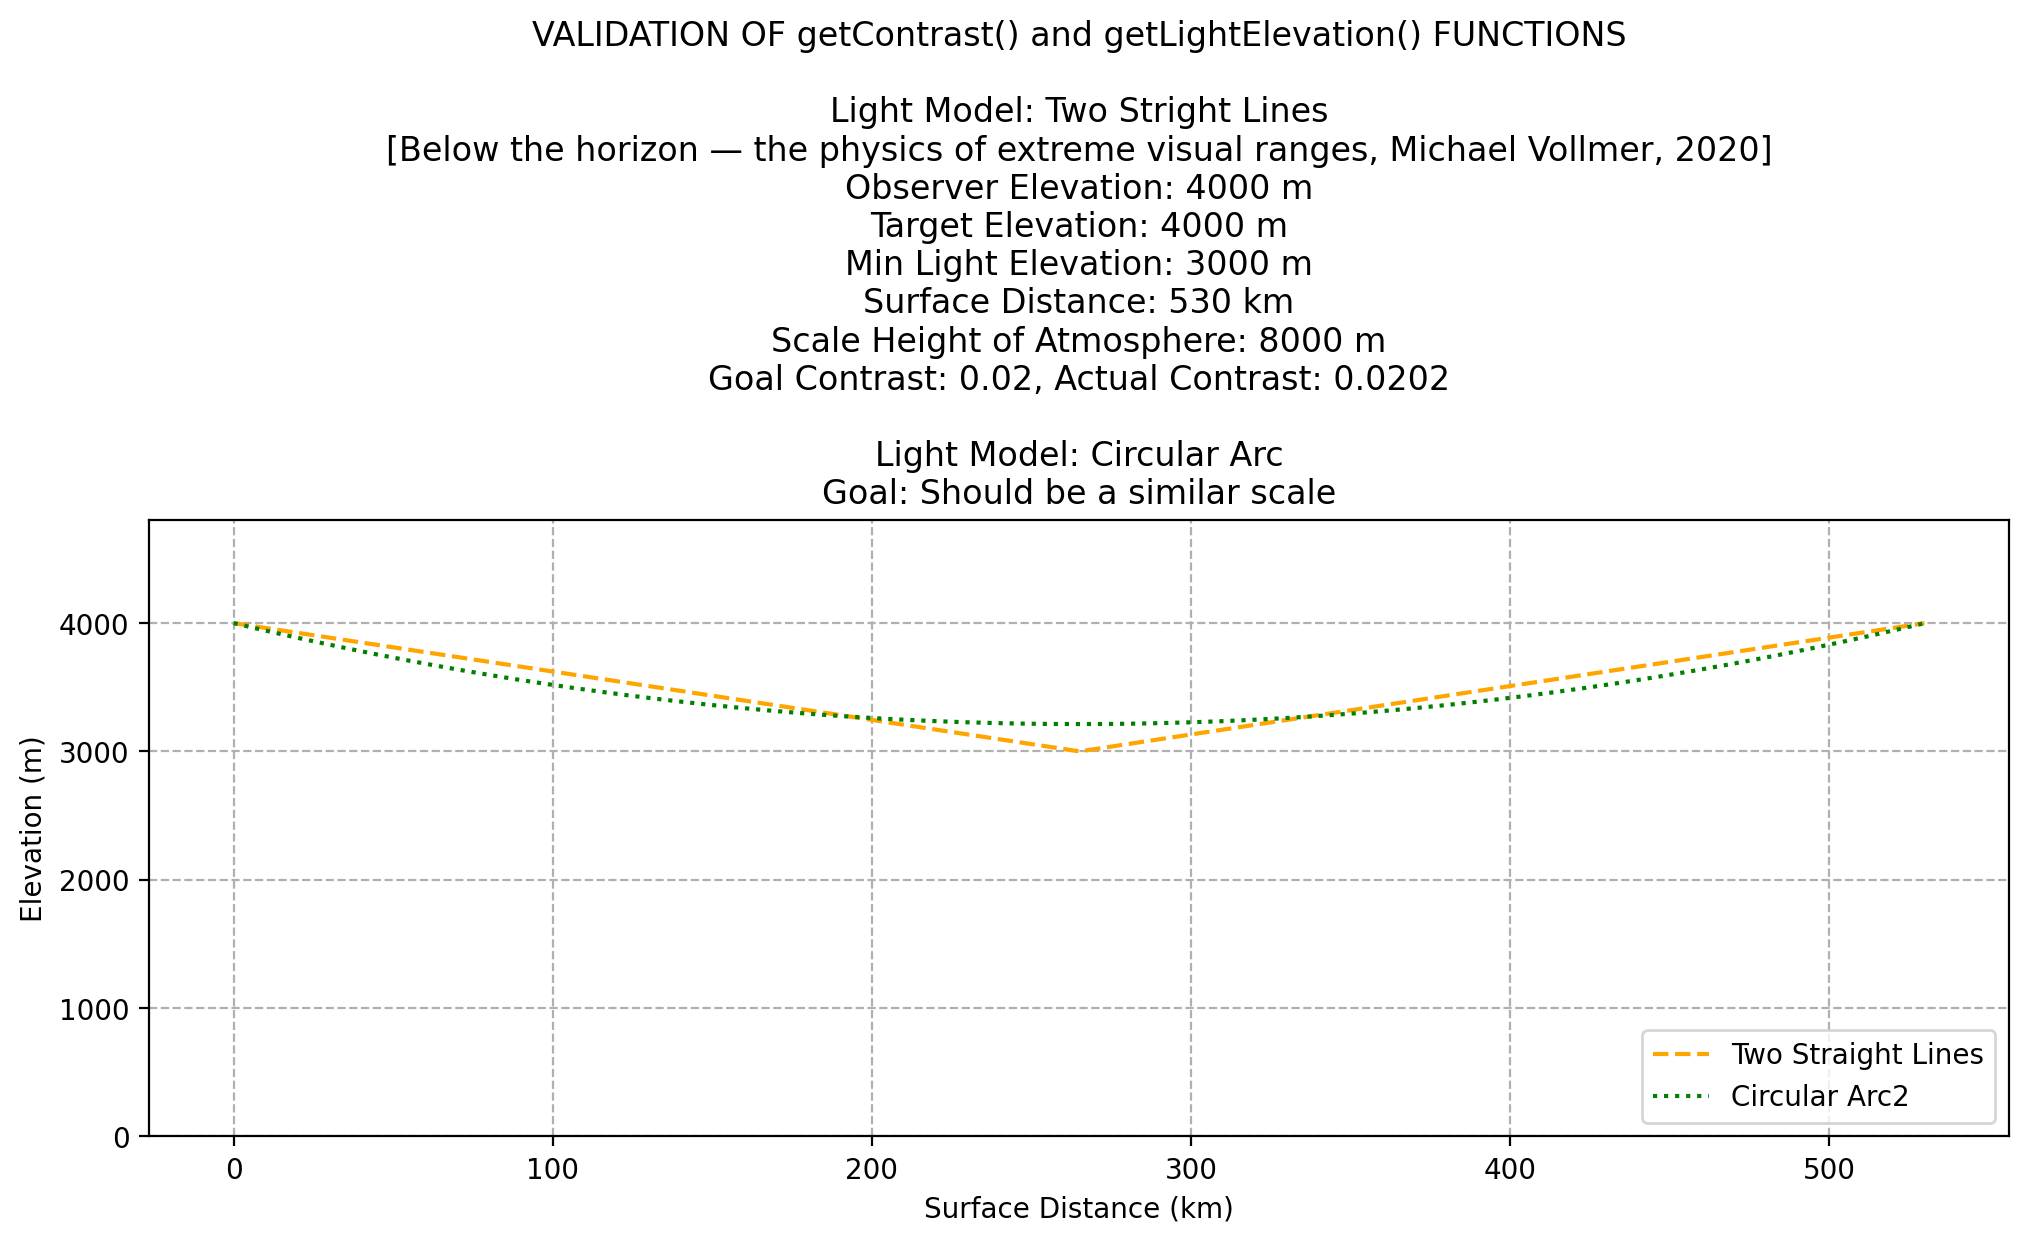

In [7]:
import math
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

B0 = 0.00001139
H = 8000

h1 = 4000
h2 = 4000
D = 530000
C = 1.167
R = 6371000

def getLightElevation(x, h1, h2, D, C, R):

    theta = x/R
    phi = D/R

    x1 = R + h1
    y1 = 0

    x2 = (R+h2)*math.cos(phi)
    y2 = (R+h2)*math.sin(phi)

    d = math.sqrt((x2-x1)**2 + (y2-y1)**2)

    RL = C*R

    Z = math.sqrt(RL**2 - (d/2)**2)

    Mx = (x1+x2)/2 - Z*((y2-y1)/d)
    My = (y1+y2)/2 + Z*((x2-x1)/d)

    L0 = (Mx*math.cos(theta)+My*math.sin(theta)) + math.sqrt((Mx*math.cos(theta)+My*math.sin(theta))**2 - (Mx**2 + My**2 - RL**2))
    
    return L0 - R
    
def getLightElevationStraight(x, h1, h2, D, C, R):
    mid = 3000
    mid_x = D/2
    
    if x <= mid_x:
        return h1 + (mid-h1)*(x/mid_x)
    else:
        return mid + (h2-mid)*((x-mid_x)/mid_x)

def getScatterCoef(h, H):
    return B0 * math.exp(-h/H)

X = np.arange(0, D, 100)
Y_Straight = [getLightElevationStraight(x, h1, h2, D, C, R) for x in X]

resultStraight, error = quad(lambda x: getScatterCoef(getLightElevationStraight(x, h1, h2, D, C, R), H), 0, D)

B_avg_Straight = resultStraight/D

contrastStraight = math.exp(-B_avg_Straight*D)

Y = [getLightElevation(x, h1, h2, D, C, R) for x in X]

result, error = quad(lambda x: getScatterCoef(getLightElevation(x, h1, h2, D, C, R), H), 0, D)

B_avg = result/D

contrast = math.exp(-B_avg*D)

print(contrast, contrastStraight)

plt.figure(figsize=(12, 4), facecolor="white", dpi=200)

plt.plot(X/1000, Y_Straight, c="orange", ls="--", label="Two Straight Lines")
plt.plot(X/1000, Y, c="green", label="Circular Arc2", ls=":")

plt.ylim(bottom=0, top=max(Y)*1.2)

plt.xlabel("Surface Distance (km)")
plt.ylabel("Elevation (m)")
plt.title(f"VALIDATION OF getContrast() and getLightElevation() FUNCTIONS\n\n"

          "Light Model: Two Stright Lines\n" + 
          "[Below the horizon — the physics of extreme visual ranges, Michael Vollmer, 2020]\n" +
          "Observer Elevation: 4000 m\n" + 
          "Target Elevation: 4000 m\n" + 
          "Min Light Elevation: 3000 m\n" + 
          "Surface Distance: 530 km\n" + 
          "Scale Height of Atmosphere: 8000 m\n" + 
          f"Goal Contrast: 0.02, Actual Contrast: {round(contrastStraight, 4)}\n\n" + 
          
          f"Light Model: Circular Arc\n" + 
          "Goal: Should be a similar scale")

plt.grid(True, ls="--", zorder=0)

ax = plt.gca()
ax.set_facecolor("white")
plt.legend(loc = 4)

# plt.savefig("../misc/images/scatter_validation", bbox_inches="tight")
plt.show()

In [10]:
testCurvature = 7.7 # Max light curvature to test
knownLos['curvature'] = None

while sum(knownLos.curvature.isna()) > 0 and testCurvature >= 1.0: # testCurvature = 1 gives the best LOS conditions

    print(f'Test Curvature: {round(testCurvature, 1)}')
    print(f'LOS Remaining: {sum(knownLos.curvature.isna())}\n')

    missingCurvatureMask = knownLos.curvature.isna()

    for i in knownLos.index[missingCurvatureMask]:
        los = knownLos.loc[i]
    
        observer = me.Summit(latitude=los.from_latitude,
                             longitude=los.from_longitude,
                             elevation=los.from_elevation)

        target = me.Summit(latitude=los.to_latitude,
                           longitude=los.to_longitude,
                           elevation=los.to_elevation)
    
        lineOfSight = me.LineOfSight(observer, target, lightCurvature=testCurvature)
        lineOfSight.processFullLineOfSight()
    
        if not lineOfSight.isObstructed() and lineOfSight.hasContrast():
            knownLos.at[i, 'curvature'] = round(testCurvature, 1)
    
    allCurvaturesFound = knownLos.curvature.notna().all()
    
    testCurvature -= 0.1

Test Curvature: 7.7
LOS Remaining: 34

Test Curvature: 7.6
LOS Remaining: 9

Test Curvature: 7.5
LOS Remaining: 9

Test Curvature: 7.4
LOS Remaining: 9

Test Curvature: 7.3
LOS Remaining: 9

Test Curvature: 7.2
LOS Remaining: 9

Test Curvature: 7.1
LOS Remaining: 9

Test Curvature: 7.0
LOS Remaining: 8

Test Curvature: 6.9
LOS Remaining: 8

Test Curvature: 6.8
LOS Remaining: 8

Test Curvature: 6.7
LOS Remaining: 8

Test Curvature: 6.6
LOS Remaining: 8

Test Curvature: 6.5
LOS Remaining: 8

Test Curvature: 6.4
LOS Remaining: 8

Test Curvature: 6.3
LOS Remaining: 7

Test Curvature: 6.2
LOS Remaining: 7

Test Curvature: 6.1
LOS Remaining: 7

Test Curvature: 6.0
LOS Remaining: 7

Test Curvature: 5.9
LOS Remaining: 7

Test Curvature: 5.8
LOS Remaining: 6

Test Curvature: 5.7
LOS Remaining: 6

Test Curvature: 5.6
LOS Remaining: 6

Test Curvature: 5.5
LOS Remaining: 6

Test Curvature: 5.4
LOS Remaining: 6

Test Curvature: 5.3
LOS Remaining: 6

Test Curvature: 5.2
LOS Remaining: 6

Test Curvat